# Use PyTorch to recognize hand-written digits with `ibm-watson-machine-learning`

This notebook contains steps and code to demonstrate support of Deep Learning model training and scoring in Watson Machine Learning service. It introduces commands for getting data, training_definition persistance to Watson Machine Learning repository, model training, model persistance, model deployment and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.8.


## Learning goals

The learning goals of this notebook are:

-  Working with Watson Machine Learning service.
-  Training Deep Learning models (TensorFlow).
-  Saving trained models in Watson Machine Learning repository.
-  Online deployment and scoring of trained model.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Create model definition](#model_def)
3.	[Train model](#training)
4.  [Persist trained model](#persist)
5.	[Deploy and Score](#deploy)
6.  [Clean up](#clean)
7.	[Summary and next steps](#summary)

<a id="setup"></a>
## 1. Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-service-instance.html?context=analytics" target="_blank" rel="noopener no referrer">here</a>).

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud. You need to provide platform `api_key` and instance `location`.

You can use [IBM Cloud CLI](https://cloud.ibm.com/docs/cli/index.html) to retrieve platform API Key and instance location.

API Key can be generated in the following way:
```
ibmcloud login
ibmcloud iam api-key-create API_KEY_NAME
```

In result, get the value of `api_key` from the output.


Location of your WML instance can be retrieved in the following way:
```
ibmcloud login --apikey API_KEY -a https://cloud.ibm.com
ibmcloud resource service-instance WML_INSTANCE_NAME
```

In result, get the value of `location` from the output.

**Tip**: Your `Cloud API key` can be generated by going to the [**Users** section of the Cloud console](https://cloud.ibm.com/iam#/users). From that page, click your name, scroll down to the **API Keys** section, and click **Create an IBM Cloud API key**. Give your key a name and click **Create**, then copy the created key and paste it below. You can also get a service specific url by going to the [**Endpoint URLs** section of the Watson Machine Learning docs](https://cloud.ibm.com/apidocs/machine-learning).  You can check your instance location in your  <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance details.

You can also get service specific apikey by going to the [**Service IDs** section of the Cloud Console](https://cloud.ibm.com/iam/serviceids).  From that page, click **Create**, then copy the created key and paste it below.

**Action**: Enter your `api_key` and `location` in the following cell.

In [1]:
api_key = ''
location = 'us-south'

In [2]:
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}

### Install and import the `ibm-watson-machine-learning` package
**Note:** `ibm-watson-machine-learning` documentation can be found <a href="http://ibm-wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.

In [14]:
!pip install ibm-watson-machine-learning wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9681 sha256=e6af3e60702005bdd973bd0493e4eaed250e987936d03e08a46ec68fdd29be7a
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [4]:
from ibm_watson_machine_learning import APIClient

client = APIClient(wml_credentials)

### Working with spaces

First of all, you need to create a space that will be used for your work. If you do not have space already created, you can use [Deployment Spaces Dashboard](https://dataplatform.cloud.ibm.com/ml-runtime/spaces?context=cpdaas) to create one.

- Click New Deployment Space
- Create an empty space
- Select Cloud Object Storage
- Select Watson Machine Learning instance and press Create
- Copy `space_id` and paste it below

**Tip**: You can also use SDK to prepare the space for your work. More information can be found [here](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Space%20management.ipynb).

**Action**: Assign space ID below

In [5]:
space_id = ''

You can use `list` method to print all existing spaces.

In [6]:
client.spaces.list(limit=10)

------------------------------------  -----------  ------------------------
ID                                    NAME         CREATED
5808d8c4-22a7-4610-a2d5-861d52401a37  mnist-space  2022-02-11T23:31:35.944Z
------------------------------------  -----------  ------------------------


To be able to interact with all resources available in Watson Machine Learning, you need to set **space** which you will be using.

In [7]:
client.set.default_space(space_id)

'SUCCESS'

### 1.1 Working with Cloud Object Storage

-  Create a [Cloud Object Storage (COS)](https://console.bluemix.net/catalog/infrastructure/cloud-object-storage) instance (a lite plan is offered and information about how to order storage is [here](https://console.bluemix.net/docs/services/cloud-object-storage/basics/order-storage.html#order-storage)).
    - After you create COS instance, go to your COS dashboard.
    - In **Service credentials** tab, click **New Credential**.
    - Add the inline configuration parameter: {["HMAC"](https://console.bluemix.net/docs/services/cloud-object-storage/hmac/credentials.html#using-hmac-credentials):true}, click **Add**.

    This configuration parameter adds the following section to the instance credentials, (for use later in this notebook):
    ```
      "cos_hmac_keys": {
            "access_key_id": "***",
            "secret_access_key": "***"
       }
    ```

`ibm-cos-sdk` library allows Python developers to manage Cloud Object Storage (COS).

In [8]:
import ibm_boto3
import os
import json
from ibm_botocore.client import Config

**Action**: Enter your COS credentials in the following cell.  
You can find these credentials in your COS instance dashboard under the **Service credentials** tab.  
**Note** the HMAC key, described in [set up the environment](#setup) is included in these credentials.

In [9]:
cos_credentials = {
  "apikey": "2UkxsRDCx7jDvA04AgdaO0FI2TEuA-Z9hIIUZhD4Zyqe",
  "cos_hmac_keys": {
    "access_key_id": "b61629360b56459ab3273318b31a7f64",
    "secret_access_key": "a10073f7bcae9278dcb6c92218417f6c124578f90825efbb"
  },
  "endpoints": "https://control.cloud-object-storage.cloud.ibm.com/v2/endpoints",
  "iam_apikey_description": "Auto-generated for key crn:v1:bluemix:public:cloud-object-storage:global:a/7d0717b570cb4f35bdef5deb642380b8:284a09ae-4332-487b-875f-75bd8878cbe4:resource-key:b6162936-0b56-459a-b327-3318b31a7f64",
  "iam_apikey_name": "srs9969-service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/7d0717b570cb4f35bdef5deb642380b8::serviceid:ServiceId-38d59347-58e7-41ee-abf9-e293933e9e47",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/7d0717b570cb4f35bdef5deb642380b8:284a09ae-4332-487b-875f-75bd8878cbe4::"
}

api_key = cos_credentials['apikey']
service_instance_id = cos_credentials['resource_instance_id']
auth_endpoint = 'https://iam.cloud.ibm.com/identity/token'
service_endpoint = 'https://s3.us-south.cloud-object-storage.appdomain.cloud'

We create COS resource to be able to write data to Cloud Object Storage.

In [10]:
cos = ibm_boto3.resource('s3',
                         ibm_api_key_id=api_key,
                         ibm_service_instance_id=service_instance_id,
                         ibm_auth_endpoint=auth_endpoint,
                         config=Config(signature_version='oauth'),
                         endpoint_url=service_endpoint)

Let's create the buckets (they have to have unique names), we will use to store training data and training results.

In [11]:
from uuid import uuid4

bucket_uid = str(uuid4())
buckets = ['training-data-' + bucket_uid, 'training-results-' + bucket_uid]

for bucket in buckets:
    if not cos.Bucket(bucket) in cos.buckets.all():
        print('Creating bucket "{}"...'.format(bucket))
        try:
            cos.create_bucket(Bucket=bucket)
        except ibm_boto3.exceptions.ibm_botocore.client.ClientError as e:
            print('Error: {}.'.format(e.response['Error']['Message']))

Creating bucket "training-data-09df40e8-dec6-4336-9cb3-1fcae1a772f7"...
Creating bucket "training-results-09df40e8-dec6-4336-9cb3-1fcae1a772f7"...


Now we should have 2 buckets,

### 1.2 Downloading training data and upload it to COS buckets.

Let's download our training data and upload them to 'training-data' bucket.
We will create a list of links for training dataset

In [12]:
link = 'https://s3.amazonaws.com/img-datasets/mnist.npz'

In [15]:
import wget

data_dir = 'MNIST_DATA'
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

if not os.path.isfile(os.path.join(data_dir, os.path.join(link.split('/')[-1]))):
    wget.download(link, out=data_dir)  

Below snippet will upload files from links to your Cloud Object Storage.

In [16]:
bucket_name = buckets[0]
bucket_obj = cos.Bucket(bucket_name)

for filename in os.listdir(data_dir):
    with open(os.path.join(data_dir, filename), 'rb') as data: 
        bucket_obj.upload_file(os.path.join(data_dir, filename), filename)
        print('{} is uploaded.'.format(filename))

mnist.npz is uploaded.


Let's see the list of all created buckets and their contents.

In [17]:
for bucket_name in buckets:
    print(bucket_name)
    bucket_obj = cos.Bucket(bucket_name)
    for obj in bucket_obj.objects.all():
        print("  File: {}, {:4.2f}kB".format(obj.key, obj.size/1024))

training-data-09df40e8-dec6-4336-9cb3-1fcae1a772f7
  File: mnist.npz, 11221.13kB
training-results-09df40e8-dec6-4336-9cb3-1fcae1a772f7


### 1.3 Create connections to a COS bucket.

In [20]:
datasource_type = client.connections.get_datasource_type_uid_by_name('bluemixcloudobjectstorage')

input_conn_meta_props= {
    client.connections.ConfigurationMetaNames.NAME: "Input COS connection",
    client.connections.ConfigurationMetaNames.DATASOURCE_TYPE: datasource_type,
    client.connections.ConfigurationMetaNames.PROPERTIES: {
        'bucket': buckets[0],
        'access_key': cos_credentials['cos_hmac_keys']['access_key_id'],
        'secret_key': cos_credentials['cos_hmac_keys']['secret_access_key'],
        'iam_url': auth_endpoint,
        'url': service_endpoint
    }
}

output_conn_meta_props= {
    client.connections.ConfigurationMetaNames.NAME: "Output COS connection",
    client.connections.ConfigurationMetaNames.DATASOURCE_TYPE: datasource_type,
    client.connections.ConfigurationMetaNames.PROPERTIES: {
        'bucket': buckets[1],
        'access_key': cos_credentials['cos_hmac_keys']['access_key_id'],
        'secret_key': cos_credentials['cos_hmac_keys']['secret_access_key'],
        'iam_url': auth_endpoint,
        'url': service_endpoint
    }
}

input_conn_details = client.connections.create(meta_props=input_conn_meta_props)
output_conn_details = client.connections.create(meta_props=output_conn_meta_props)

Creating connections...
SUCCESS
Creating connections...
SUCCESS


In [21]:
input_connection_id = client.connections.get_uid(input_conn_details)
output_connection_id = client.connections.get_uid(output_conn_details)

We are done with Cloud Object Storage, we are ready to train our model!

<a id="model_def"></a>
# 2. Create model definition

### 2.1 Prepare model definition metadata

In [22]:
model_definition_metadata = {
    client.model_definitions.ConfigurationMetaNames.NAME: "PyTorch Hand-written Digit Recognition",
    client.model_definitions.ConfigurationMetaNames.DESCRIPTION: "PyTorch Hand-written Digit Recognition",
    client.model_definitions.ConfigurationMetaNames.COMMAND:  "python3 torch_mnist.py --epochs 1",
    client.model_definitions.ConfigurationMetaNames.PLATFORM: {"name": "python", "versions": ["3.8"]},
    client.model_definitions.ConfigurationMetaNames.VERSION: "2.0",
    client.model_definitions.ConfigurationMetaNames.SPACE_UID: space_id
}

### 2.2  Get sample model definition content file from git

In [23]:
import wget

filename='pytorch-model.zip'

if not os.path.isfile(filename):
    filename = wget.download('https://github.com/IBM/watson-machine-learning-samples/raw/master/cloud/definitions/pytorch/mnist/pytorch-model.zip')

**Tip**: Convert below cell to code and run it to see model deinition's code.

In [24]:
!unzip -oqd . pytorch-model.zip && cat torch_mnist.py

from __future__ import print_function
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class CustomTensorDataset(torch.utils.data.Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.x)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

   

### 2.3  Publish model definition

In [25]:
definition_details = client.model_definitions.store(filename, model_definition_metadata)

In [26]:
model_definition_id = client.model_definitions.get_id(definition_details)
print(model_definition_id)

734b62ba-1d52-444a-b29e-15b60e2255cb


#### List models definitions

In [27]:
client.model_definitions.list(limit=5)

--------------------------------------  --------------------  ------------------------------------
NAME                                    ASSET_TYPE            GUID
PyTorch Hand-written Digit Recognition  wml_model_definition  734b62ba-1d52-444a-b29e-15b60e2255cb
--------------------------------------  --------------------  ------------------------------------


<a id="training"></a>
# 3. Train model

### 3.1 Prepare training metadata

In [28]:
training_metadata = training_metadata = {
   client.training.ConfigurationMetaNames.NAME: "PyTorch hand-written Digit Recognition",
    client.training.ConfigurationMetaNames.SPACE_UID: space_id,
    client.training.ConfigurationMetaNames.DESCRIPTION: "PyTorch hand-written Digit Recognition",
    client.training.ConfigurationMetaNames.TAGS :[{
      "value": "PyTorch_mnsit",
      "description": "PyTorch mnist recognition"
    }],
    client.training.ConfigurationMetaNames.TRAINING_RESULTS_REFERENCE:  {
    "name": "PyTorch MNIST results",
    "connection": {
            "id": output_connection_id,
      },
      "location": {
        "bucket": buckets[1],
        "file_name": "."
      },
    "type": "connection_asset"
  },
  client.training.ConfigurationMetaNames.MODEL_DEFINITION:{
        "id": model_definition_id,
        "hardware_spec": {
          "name": "K80",
          "nodes": 1
        },
        "software_spec": {
          "name": "pytorch-onnx_1.7-py3.8"
        },
        "parameters": {
          "name": "PyTorch hand-written Digit Recognition",
          "description": "PyTorch hand-written Digit Recognition"
        }
  },
  client.training.ConfigurationMetaNames.TRAINING_DATA_REFERENCES: [
    {
      "name": "training_input_data",
      "type": "connection_asset",
      "connection": {
          "id": input_connection_id,
      },
      "location": {
        "bucket": buckets[0],
        "file_name": "."
      },
      "schema": {
        "id":"idmlp_schema",
        "fields": [
          {
            "name": "text",
            "type": "string"
          }
        ]
      }
    }
  ]
}

### 3.2 Train the model in the background

In [29]:
training = client.training.run(training_metadata)

### 3.3 Get training id and status

In [30]:
training_id = client.training.get_id(training)
print(training_id)

53a312f0-bab7-4d20-bf87-0ff7680b9c63


In [36]:
client.training.get_status(training_id)['state']

'completed'

### 3.4 Get training details

In [37]:
training_details = client.training.get_details(training_id)
print(json.dumps(training_details, indent=2))

{
  "metadata": {
    "created_at": "2022-02-12T00:22:06.180Z",
    "description": "PyTorch hand-written Digit Recognition",
    "id": "53a312f0-bab7-4d20-bf87-0ff7680b9c63",
    "modified_at": "2022-02-12T00:25:39.634Z",
    "name": "PyTorch hand-written Digit Recognition",
    "space_id": "5808d8c4-22a7-4610-a2d5-861d52401a37",
    "tags": [
      "PyTorch_mnsit"
    ]
  },
  "entity": {
    "description": "PyTorch hand-written Digit Recognition",
    "model_definition": {
      "hardware_spec": {
        "name": "K80"
      },
      "id": "734b62ba-1d52-444a-b29e-15b60e2255cb",
      "parameters": {
        "description": "PyTorch hand-written Digit Recognition",
        "name": "PyTorch hand-written Digit Recognition"
      },
      "software_spec": {
        "name": "pytorch-onnx_1.7-py3.8"
      }
    },
    "name": "PyTorch hand-written Digit Recognition",
    "results_reference": {
      "connection": {
        "id": "c0a128c9-eed7-4d0d-bd7c-dfe023e86afa"
      },
      "locati

#### List trainings

In [38]:
client.training.list(limit=5)

------------------------------------  ---------  ------------------------
ID (training)                         STATE      CREATED
53a312f0-bab7-4d20-bf87-0ff7680b9c63  completed  2022-02-12T00:22:06.180Z
------------------------------------  ---------  ------------------------


,ID (training),STATE,CREATED
0,53a312f0-bab7-4d20-bf87-0ff7680b9c63,completed,2022-02-12T00:22:06.180Z


#### Cancel training

You can cancel the training run by calling the method below.  
**Tip**: If you want to  delete train runs and results add `hard_delete=True` as a parameter.

<a id="persist"></a>
# 4. Persist trained model

### 4.1 Download trained model from COS

In [39]:
uid = client.training.get_details(training_id)['entity']['results_reference']['location']['logs']

#### Download model from COS

In [40]:
bucket_name = buckets[1]
bucket_obj = cos.Bucket(bucket_name)

model_path = ""
for obj in bucket_obj.objects.iterator():
    if uid in obj.key and obj.key.endswith(".onnx"):
        model_path = obj.key
        break

model_name = model_path.split("/")[-1]
bucket_obj.download_file(model_path, model_name)

#### Unpack model and compress it to tar.gz format

In [41]:
import tarfile
    
with tarfile.open(model_name.split('.')[0] + ".tar.gz", "w:gz") as tar:
    tar.add(model_name)
    
model_name = model_name.split('.')[0] + ".tar.gz"
print(model_name)

mnist_cnn.tar.gz


### 4.2 Publish model

In [42]:
software_spec_uid = client.software_specifications.get_id_by_name('pytorch-onnx_1.7-py3.8')

In [43]:
model_meta_props = {client.repository.ModelMetaNames.NAME: "PyTorch Mnist Model",
                    client.repository.ModelMetaNames.TYPE: "pytorch-onnx_1.7",
                    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
                    }

published_model_details = client.repository.store_model(model=model_name, meta_props=model_meta_props)
model_uid = client.repository.get_model_uid(published_model_details)

This method is deprecated, please use get_model_id()


/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/ibm_watson_machine_learning/repository.py:1458: UserWarning: This method is deprecated, please use get_model_id()
  warn("This method is deprecated, please use get_model_id()")


### 4.3 Get model details

In [44]:
model_details = client.repository.get_details(model_uid)
print(json.dumps(model_details, indent=2))

{
  "entity": {
    "hybrid_pipeline_software_specs": [],
    "software_spec": {
      "id": "634d3cdc-b562-5bf9-a2d4-ea90a478456b",
      "name": "pytorch-onnx_1.7-py3.8"
    },
    "type": "pytorch-onnx_1.7"
  },
  "metadata": {
    "created_at": "2022-02-12T00:27:22.147Z",
    "id": "ae3f932b-02d8-406e-8850-a250e29d1652",
    "modified_at": "2022-02-12T00:27:26.504Z",
    "name": "PyTorch Mnist Model",
    "owner": "IBMid-6620036V9N",
    "resource_key": "7128d72a-cc4f-4809-978b-4a03143b7662",
    "space_id": "5808d8c4-22a7-4610-a2d5-861d52401a37"
  },
  "system": {
    "warnings": []
  }
}


#### List stored models

In [45]:
client.repository.list_models(limit=5)

------------------------------------  -------------------  ------------------------  ----------------
ID                                    NAME                 CREATED                   TYPE
ae3f932b-02d8-406e-8850-a250e29d1652  PyTorch Mnist Model  2022-02-12T00:27:22.002Z  pytorch-onnx_1.7
------------------------------------  -------------------  ------------------------  ----------------


<a id="deploy"></a>
# 5. Deploy and score

### 5.1 Crate online deployment for published model

You can deploy the stored model as a web service (online) by running code in the following cell.

In [46]:
deployment = client.deployments.create(model_uid, meta_props={
                                            client.deployments.ConfigurationMetaNames.NAME:"PyCharm Mnist deployment",
                                            client.deployments.ConfigurationMetaNames.ONLINE:{}})

scoring_url = client.deployments.get_scoring_href(deployment)
deployment_uid = client.deployments.get_id(deployment)



#######################################################################################

Synchronous deployment creation for uid: 'ae3f932b-02d8-406e-8850-a250e29d1652' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='e7af380f-c648-4e58-9011-3d92b3f54840'
------------------------------------------------------------------------------------------------




### 5.2 Get deployments details

In [47]:
deployments_details = client.deployments.get_details(deployment_uid)
print(json.dumps(deployments_details, indent=2))

Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.
{
  "entity": {
    "asset": {
      "id": "ae3f932b-02d8-406e-8850-a250e29d1652"
    },
    "custom": {},
    "deployed_asset_type": "model",
    "hardware_spec": {
      "id": "e7ed1d6c-2e89-42d7-aed5-863b972c1d2b",
      "name": "S",
      "num_nodes": 1
    },
    "name": "PyCharm Mnist deployment",
    "online": {},
    "space_id": "5808d8c4-22a7-4610-a2d5-861d52401a37",
    "status": {
      "online_url": {
        "url": "https://us-south.ml.cloud.ibm.com/ml/v4/deployments/e7af380f-c648-4e58-9011-3d92b3f54840/predictions"
      },
      "serving_urls": [
        "https://us-south.ml.cloud.ibm.com/ml/v4/deployments/e7af380f-c648-4e58-9011-3d92b3f54840/predictions"
      ],
      "state": "ready"
    }
  },
  "metadata": {
    "created_at": "2022-02-12T00:29:06.477Z",
    "id": "e7af380f-c648-4e58-9011-3d92b3f54840",
    "modified_at": "2022-02-12T00:29:06.477Z",
    "name": "PyCharm 

### 5.3 Score deployed model

Prepare sample scoring data to score deployed model.  
**Hint:** You may need to install wget using following command `!pip install wget`

In [48]:
import numpy as np

dataset_filename='mnist.npz'
mnist_dataset = np.load(os.path.join(data_dir, dataset_filename))
x_test = mnist_dataset['x_test']

In [49]:
image_1 = [x_test[0].tolist()]
image_2 = [x_test[1].tolist()]

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

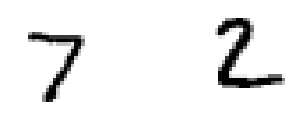

In [55]:
for i, image in enumerate([x_test[0], x_test[1]]):
    plt.subplot(2, 2, i + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')

Build scoring dictionary consisting of two digits and send it to deployed model to get predictions.

In [56]:
scoring_payload = {
    client.deployments.ScoringMetaNames.INPUT_DATA : [
        {'values': [image_1, image_2]}
    ]
}
scores = client.deployments.score(deployment_uid, meta_props=scoring_payload)
print("Scoring result:\n" + json.dumps(scores, indent=2))

Scoring result:
{
  "predictions": [
    {
      "values": [
        [
          0.0,
          0.0,
          0.0,
          0.0,
          0.0,
          0.0,
          0.0,
          1.0,
          0.0,
          0.0
        ],
        [
          0.0,
          0.0,
          1.0,
          0.0,
          0.0,
          0.0,
          0.0,
          0.0,
          0.0,
          0.0
        ]
      ]
    }
  ]
}


#### List deployments

In [57]:
client.deployments.list(limit=5)

------------------------------------  ------------------------  -----  ------------------------
GUID                                  NAME                      STATE  CREATED
e7af380f-c648-4e58-9011-3d92b3f54840  PyCharm Mnist deployment  ready  2022-02-12T00:29:06.477Z
------------------------------------  ------------------------  -----  ------------------------


<a id="clean"></a>
# 6. Clean up

If you want to clean up all created assets:
- experiments
- trainings
- pipelines
- model definitions
- models
- functions
- deployments

please follow up this sample [notebook](https://github.com/IBM/watson-machine-learning-samples/blob/master/cloud/notebooks/python_sdk/instance-management/Machine%20Learning%20artifacts%20management.ipynb).

<a id="summary"></a>
# 7. Summary and next steps     

 You successfully completed this notebook! You learned how to use `ibm-watson-machine-learning-client` to train and score PyTorch models. Check out our [Online Documentation](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/ml-service-instance.html?context=analytics) for more samples, tutorials, documentation, how-tos, and blog posts. 

### Author

**Jan Sołtysik**, Intern in Watson Machine Learning.

Copyright © 2020, 2021, 2022 IBM. This notebook and its source code are released under the terms of the MIT License.